## Домашняя работа 4.

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать:

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов:
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data.adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


In [4]:
df.shape

(16280, 14)

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html).

В данном датасете пропущенные значения обозначены как "?".

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [5]:
df.replace("?", np.nan, inplace=True)
df = df.dropna()
df.shape

(15347, 14)

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем:

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [6]:
y = df['>50K,<=50K']
df = df.drop('>50K,<=50K', axis = 1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40


In [7]:
y.head()

0    <=50K
1    <=50K
2    <=50K
3    <=50K
4     >50K
Name: >50K,<=50K, dtype: object

In [8]:
y = y.apply(lambda x: 1 if x == '<=50K' else 0)
y.head()

0    1
1    1
2    1
3    1
4    0
Name: >50K,<=50K, dtype: int64

In [9]:
X_real = df[['age', 'fnlwgt', 'education-num','capital-gain', 'capital-loss', 'hours-per-week']]

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)

Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

In [10]:
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

In [11]:
def grid_search_plot(model, params, name):
    grid = GridSearchCV(model, param_grid = params, cv = 5, scoring = 'roc_auc')
    grid.fit(X_real, y)

    print(f'Best ROC_AUC: {grid.best_score_}')

    mean = grid.cv_results_['mean_test_score']
    std = grid.cv_results_['std_test_score']
    x = list(params.values())[0]

    above = mean + std
    under = mean - std

    plt.style.use('ggplot')
    plt.plot(x, mean, linewidth=3, color = 'black')
    plt.fill_between(x, above, under, alpha = 0.3, color = 'gray')
    plt.title(name)
    plt.xlabel(list(params.keys())[0])
    plt.xticks(rotation = 25)
    plt.ylabel('roc_auc');

Best ROC_AUC: 0.6407153603874729


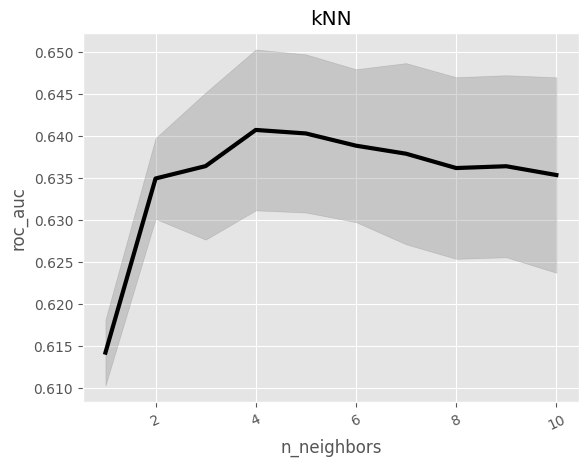

In [12]:
model = KNeighborsClassifier()
params = {'n_neighbors': np.arange(1, 11, 1)}

grid_search_plot(model, params, 'kNN')

Best ROC_AUC: 0.8414345948566877


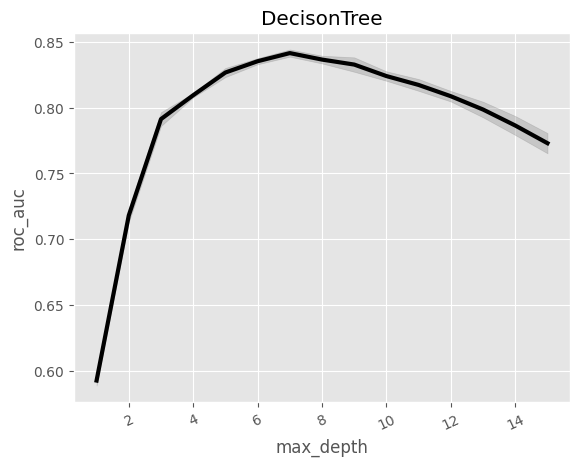

In [13]:
model = DecisionTreeClassifier(random_state=42)
params = {'max_depth': np.arange(1, 16, 1)}

grid_search_plot(model, params, 'DecisonTree')

Best ROC_AUC: 0.609055248053272


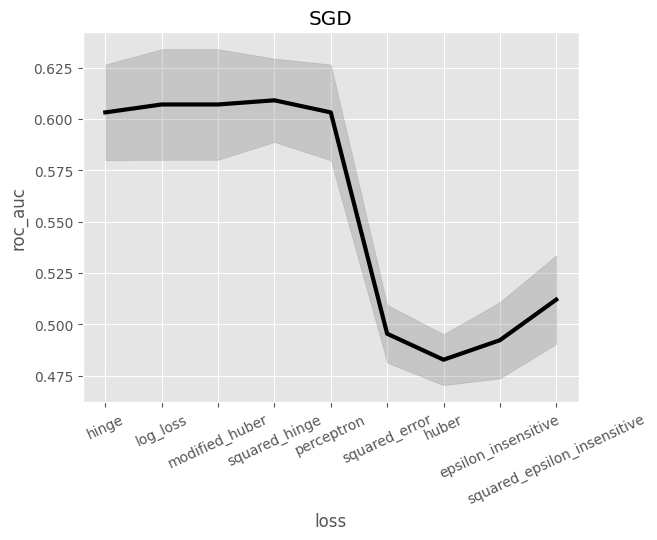

In [14]:
model = SGDClassifier(random_state=42)
params = {'loss': ['hinge', 'log_loss', 'modified_huber',
                  'squared_hinge', 'perceptron', 'squared_error',
                  'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}

grid_search_plot(model, params, 'SGD')

Что вы можете сказать о получившихся графиках?

***Самой лучшей моделью оказалась DecisionTree(дисперсия минимальна, а roc-auc высокий), а худшей SGD.***

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_real, y, train_size=0.8, random_state=42)

def task_3_4_6(model, task=3):
    trees_pr = []
    for tree in model.estimators_:
        if (task == 3) or (task == 6.1):
            tree_pr = tree.predict(X_test)
        else:
            tree_pr = tree[0].predict(X_test)
        trees_pr.append(tree_pr)

    roc_auc_list = []

    for i in range(1, len(model.estimators_)+1):
        subset_pr = np.array(trees_pr[:i]).mean(axis=0)
        roc_auc_subset = roc_auc_score(y_test, subset_pr)
        roc_auc_list.append(roc_auc_subset)
        
    print(f'Best ROC_AUC: {max(roc_auc_list)}')
    if task < 6:
        plt.plot(roc_auc_list)
        plt.xlabel('Number of trees')
        plt.ylabel('Roc_auc');
        print(f'кол-во деревьев: {roc_auc_list.index(max(roc_auc_list)) + 1}')

Best ROC_AUC: 0.814105927728239
кол-во деревьев: 542


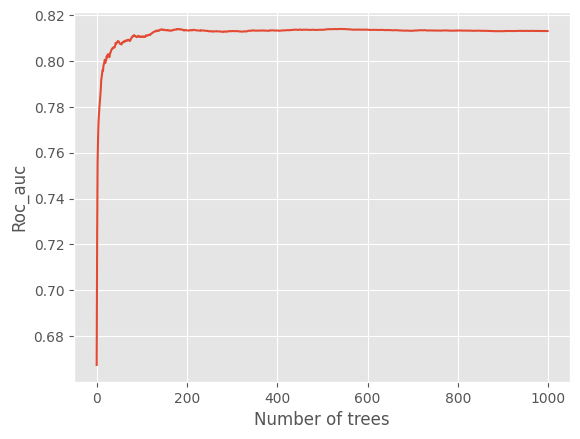

In [16]:
model = RandomForestClassifier(n_estimators = 1000, random_state=42)
model.fit(X_train, y_train)

task_3_4_6(model)

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

Best ROC_AUC: 0.8619899243771251
кол-во деревьев: 346


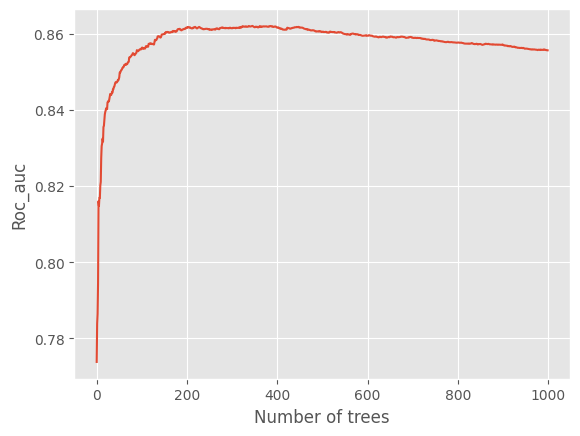

In [17]:
model = GradientBoostingClassifier(n_estimators = 1000, random_state=42)
model.fit(X_train, y_train)

task_3_4_6(model, 4)

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масштабирование повлиять на работу этих алгоритмов?

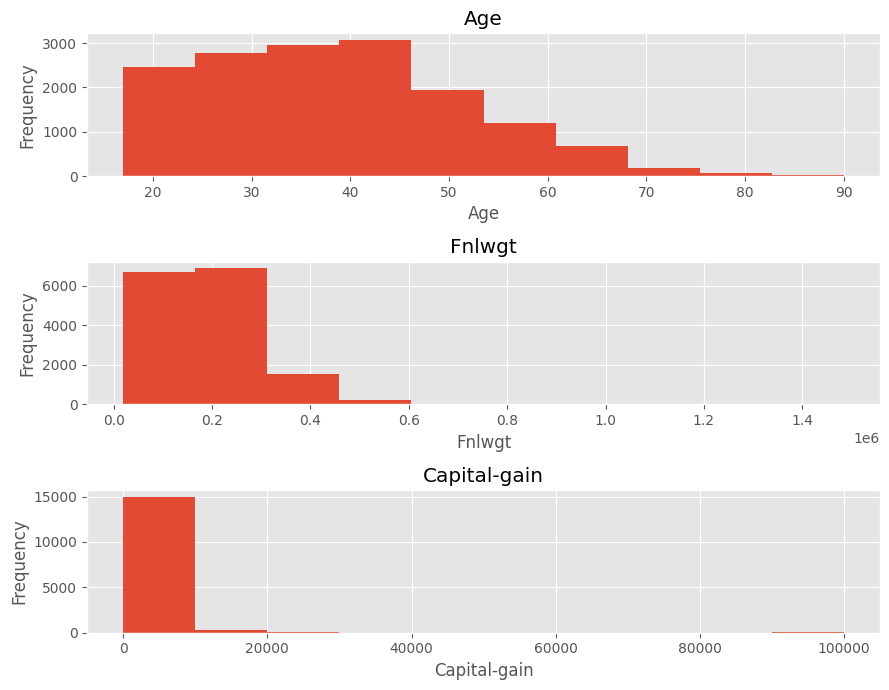

In [18]:
fig, axs = plt.subplots(3, figsize=(9, 7))

axs[0].hist(X_real.age)
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Age')

axs[1].hist(X_real.fnlwgt)
axs[1].set_xlabel('Fnlwgt')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Fnlwgt')

axs[2].hist(X_real['capital-gain'])
axs[2].set_xlabel('Сapital-gain')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Capital-gain')

fig.tight_layout()

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).

**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_real, y, train_size=0.8, random_state=42)

In [20]:
from sklearn.preprocessing import StandardScaler
scaler_x = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

In [21]:
def pred(model, params):
    kf = KFold(n_splits=5)
    grid = GridSearchCV(model, param_grid=params, cv=kf, scoring='roc_auc')
    grid.fit(X_real, y)
    
    print(f'Best ROC_AUC: {grid.best_score_}')
    print(grid.best_params_)

In [22]:
model = KNeighborsClassifier()
params = {'n_neighbors': np.arange(1, 10, 1)}

pred(model, params)

Best ROC_AUC: 0.6413259277473781
{'n_neighbors': 5}


In [23]:
model = DecisionTreeClassifier(random_state=42)
params = {'max_depth': np.arange(1, 15, 1)}

pred(model, params)

Best ROC_AUC: 0.8410137099534056
{'max_depth': 7}


In [24]:
model = SGDClassifier(random_state=42)
params = {'loss': ['hinge', 'log_loss', 'modified_huber', 
                  'squared_hinge', 'perceptron', 'squared_error', 
                  'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}

pred(model, params)

Best ROC_AUC: 0.6166849732833735
{'loss': 'squared_hinge'}


In [25]:
model = RandomForestClassifier(n_estimators = 1000, random_state=42)
model.fit(X_train, y_train)

task_3_4_6(model, 6.1)

Best ROC_AUC: 0.814105927728239


In [26]:
model = GradientBoostingClassifier(n_estimators = 1000, random_state=42)
model.fit(X_train, y_train)

task_3_4_6(model, 6.2)

Best ROC_AUC: 0.8619899243771251


Изменилось ли качество у некоторых алгоритмов?


***У SGD и knn метрика качества заметна выросла, однако нормировка не оказала значимого влияния на лес и градиентный бустинг.***

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [27]:
models = {'kNN': KNeighborsClassifier(),
          'Tree': DecisionTreeClassifier(random_state=42),
          'SGD': SGDClassifier(random_state=42),
          'Forest': RandomForestClassifier(max_features=542, random_state=42),
          'Boosting': GradientBoostingClassifier(max_features=346, random_state=42)}

params = {'kNN': {'n_neighbors': np.arange(25, 31, 1), 
                 'metric': ['cityblock', 'cosine', 'euclidean', 'haversine', 
                            'l1', 'l2', 'manhattan', 'nan_euclidean', 'minkowski']},
          'Tree': {'max_depth': np.arange(1, 20, 1),
                  'criterion': ['gini', 'entropy', 'log_loss']},
          'SGD': {'loss': ['hinge', 'log_loss', 'modified_huber', 
                           'squared_hinge', 'perceptron', 'squared_error', 
                           'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                  'penalty': ['l2', 'l1', 'elasticnet', None]},
          'Forest': {'criterion': ['gini', 'entropy', 'log_loss']},
          'Boosting': {'loss': ['log_loss', 'exponential']}}

for model in models:
    kf = KFold(n_splits=5)
    grid = GridSearchCV(models[model], param_grid=params[model], cv=kf, scoring='roc_auc')
    grid.fit(X_real, y)
    
    print(f'{model}: {grid.best_params_}')
    print(f'{model}: {grid.best_score_}')

kNN: {'metric': 'cosine', 'n_neighbors': 30}
kNN: 0.7234899606147979
Tree: {'criterion': 'entropy', 'max_depth': 8}
Tree: 0.841289133969975
SGD: {'loss': 'log_loss', 'penalty': 'l1'}
SGD: 0.6463968434511448
Forest: {'criterion': 'entropy'}
Forest: 0.8193842539108778
Boosting: {'loss': 'exponential'}
Boosting: 0.8629923086451237


Какой из алгоритмов имеет наилучшее качество?
**БУСТИНГ**

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

Лес обучался 20.6 секунд, а бустинг 16.9 секунд(в VS code подписано время выполнения каждой ячейки). Это может происходить из-за того что глубина деревьев в бустинге ограничена, а в модели случайного леса - нет.

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков.

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [28]:
X_cat = df[['workclass', 'education', 'marital-status', 'occupation',
            'relationship', 'race', 'sex', ]]
X_cat = pd.get_dummies(X_cat, drop_first = True)

In [29]:
X_cat = X_cat * 1
X_cat.head()

,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [30]:
def scale(data):
    mean_data = data.mean()
    std_data = data.std()
    data_new = (data - mean_data)/std_data
    
    return data_new

for i in X_real:
    X_real[i] = scale(X_real[i])

In [31]:
X = X_real.join(X_cat)

In [32]:
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,-0.342907,0.900229,-0.450773,-0.065597,-0.218733,1.588171,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,0.114756,0.010682,-0.059084,-0.150434,-0.218733,-0.074176,0,1,0,0,...,1,0,0,0,0,0,0,0,1,1
2,-0.190353,-0.106277,1.115984,-0.150434,-0.218733,-0.074176,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,-1.258235,-0.041381,-0.059084,-0.150434,-0.218733,-0.905349,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.648697,-0.371185,1.115984,1.995326,-0.218733,-0.074176,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1


In [33]:
models = {'kNN': KNeighborsClassifier(n_neighbors = 29, metric='cityblock'),
          'Tree': DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=42),
          'SGD': SGDClassifier(loss='log_loss', penalty='l2'),
          'Forest': RandomForestClassifier(n_estimators = 542, criterion='entropy', random_state=42),
          'Boosting': GradientBoostingClassifier(n_estimators = 346, loss='exponential', random_state=42)}

for model in models:
    print(f'Model {model}: {cross_val_score(models[model], X, y, cv = 5, scoring = "roc_auc").mean()}')

Model kNN: 0.8895263624104102
Model Tree: 0.890874570230439
Model SGD: 0.9008835660526262
Model Forest: 0.9031075622327984
Model Boosting: 0.9239855296682308


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

**Да**

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей?

In [37]:
poly = PolynomialFeatures(2)
X_poly = pd.DataFrame(poly.fit_transform(X_real))

sel = SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear', random_state=42), threshold=1e-5)
X_import_poly = pd.DataFrame(sel.fit_transform(X_poly, y))

In [39]:
ohe = pd.DataFrame(OneHotEncoder(drop='first').fit_transform(X_cat).toarray())
ohe.columns = np.arange(X_import_poly.shape[1], X_import_poly.shape[1] + max(ohe.columns) + 1, 1)
X_poly_new = X_import_poly.join(ohe)

In [40]:
models = {'kNN': KNeighborsClassifier(n_neighbors = 29, metric='cityblock'),
          'Tree': DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=42),
          'SGD': SGDClassifier(loss='log_loss', penalty='l2'),
          'Forest': RandomForestClassifier(n_estimators = 542, criterion='entropy', random_state=42),
          'Boosting': GradientBoostingClassifier(n_estimators = 346, loss='exponential', random_state=42)}

for model in models:
    print(f'Model {model}: {cross_val_score(models[model], X_poly_new, y, cv = 5, scoring = "roc_auc").mean()}')

Model kNN: 0.8869561381120962
Model Tree: 0.8895045418896025
Model SGD: 0.8911185747432112
Model Forest: 0.9009684472956438
Model Boosting: 0.9217338563662736


**Существенно увеличить качество моделей не получилось**

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [42]:
alphas = np.linspace(0, 1, 100)

roc_auc = pd.DataFrame()

for k, (train_index, test_index) in enumerate(kf.split(X)):
    clf_1 = RandomForestClassifier(n_estimators = 542, criterion='entropy', random_state=42)
    clf_2 = KNeighborsClassifier(n_neighbors = 29, metric='cityblock')
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]

    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    clf_1.fit(X_train, y_train)
    clf_2.fit(X_train, y_train)
    
    pr_1 = clf_1.predict(X_test)
    pr_2 = clf_2.predict(X_test)
    
    roc_auc_k = []
    for alpha in alphas:
        pred = pr_1*alpha + pr_2*(1-alpha)
        roc_auc_alpha = roc_auc_score(y_test, pred)
        roc_auc_k.append(roc_auc_alpha)
    
    roc_auc[k] = roc_auc_k

In [43]:
roc_auc['mean'] = roc_auc.mean(axis=1)
roc_auc['alpha'] = alphas

best_alpha = roc_auc.loc[roc_auc['mean'] == max(roc_auc['mean'])]['alpha'].values

In [44]:
max(roc_auc['mean'])

0.8093389056205108

In [ ]:
best_alpha = best_alpha[-1]


IndexError: invalid index to scalar variable.

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [47]:
models = {'kNN': KNeighborsClassifier(n_neighbors = 29, metric='cityblock'),
          'Tree': DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=42),
          'SGD': SGDClassifier(loss='log_loss', penalty='l2'),
          'Forest': RandomForestClassifier(n_estimators = 542, criterion='entropy', random_state=42),
          'Boosting': GradientBoostingClassifier(n_estimators = 346, loss='exponential', random_state=42)}

In [48]:
answer = []

for model in models:
    answer.append((model, cross_val_score(models[model], X, y, cv = 5, scoring = "roc_auc")))

In [49]:
roc_auc_list = []
for k, (train_index, test_index) in enumerate(kf.split(X)):
    clf_1 = RandomForestClassifier(n_estimators = 542, criterion='entropy', random_state=42)
    clf_2 = GradientBoostingClassifier(n_estimators = 346, loss='exponential', random_state=42)
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]

    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    clf_1.fit(X_train, y_train)
    clf_2.fit(X_train, y_train)
    
    pr_1 = clf_1.predict(X_test)
    pr_2 = clf_2.predict(X_test)
    
    pred = pr_1*best_alpha + pr_2*(1-best_alpha)
    
    roc_auc_alpha = roc_auc_score(y_test, pred)
    
    roc_auc_list.append(roc_auc_alpha)

answer.append(('Смешанная модель', np.array(roc_auc_list)))

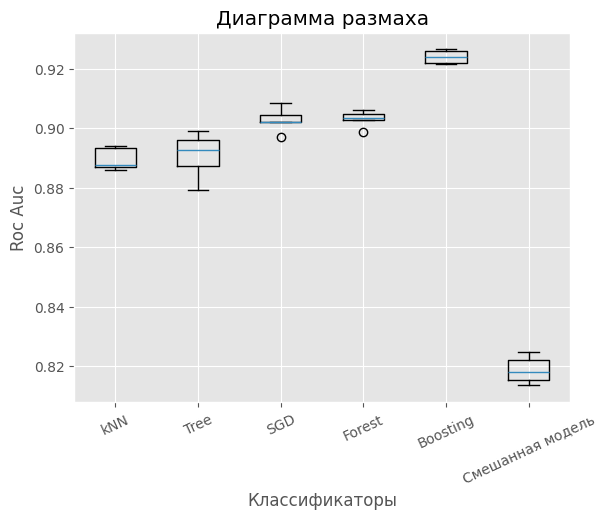

In [50]:
#plt.figure(figsize=(10, 6))
plt.boxplot([scores for name, scores in answer], labels=[name for name, scores in answer])
plt.title('Диаграмма размаха')
plt.xlabel('Классификаторы')
plt.ylabel('Roc Auc')
plt.xticks(rotation = 25);

Сложные модели (Boosting, Forest) показывают лучшие результаты, так как они могут эффективно работать с признаками, извлекая сложные зависимости.
Простые модели (kNN, Tree) менее мощны, но их легче интерпретировать, а настройка гиперпараметров проще.
Усложнение модели (увеличение количества гиперпараметров и их значений) может существенно повысить качество, но требует тщательной настройки.
Boosting выделяется как наиболее мощный классификатор, но он также требует больше вычислительных ресурсов и настройки по сравнению с другими методами.